<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# install fastkaggle if not available
#try: import fastkaggle
#except ModuleNotFoundError:
    #!pip install -Uq fastkaggle

#from fastkaggle import *

In [5]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb


from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

In [6]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T144523Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00462219b0ebe818d563608321055ba2207078282c44e3b075e950032780082a118204ce14ec335c426ca18669f9166700011d560ca2bc1641e59ca5b4bd2882a9bf146ebb14118cea90e0209e56cfc40042b62cf457c19d5f56e4b3414045b02e4dd73a4ceda38d22d36574e5241ac191c75e55da23024c1cd6ec55bf123ac183a23e3f3046e6af008197b72d7ad1fb231fa437b1c1b7ba77409812894517922f998412f8cf8c7cdfa3475fd1f1f2bde73411ba6c5f743a0f43fb518031ebfcf06064cb3887fbfb427420f7f10b32c7fb25d0754cd811191ee8179d27898d9128f54e3087eb7e2ef6760b7314facc37e1cc5839ce75130b95bbb6e60a4a4243'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2529839 bytes downloaded
Downloaded and uncompressed: playground-series-s4e4
Data source import complete.


In [7]:
#comp = 'playground-series-s4e4'

In [8]:
!ls /kaggle/input/playground-series-s4e4

sample_submission.csv  test.csv  train.csv


In [9]:
# Next, install the Kaggle API client.
#!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"7590231111c5bbe2ad242827b0ef016c"}'}

In [10]:

 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
#!kaggle datasets list


Set random seed for reproducibility.

In [11]:
#set_seed(42)

In [12]:
path = Path('/kaggle/input/playground-series-s4e4/')
path

Path('/kaggle/input/playground-series-s4e4')

Index_col

With or without.

I remove the index_col because it changes the shape of our original dataset.
 Later on we shall be able to investigate the effect of this action.

In [13]:
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')


In [19]:
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sub_df = pd.read_csv(path/'sample_submission.csv')


In [20]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [21]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')

In [22]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [23]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [24]:
to.xs.iloc[:2]

,Sex,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
84769,2,1.512905,-0.862886,-0.78115,-0.668373,-0.981039,-0.895963,-1.049124,-1.005499
52935,2,0.295932,-0.862886,-0.78115,-0.668373,-0.951531,-0.910631,-0.960017,-0.928608


In [27]:
dls = to.dataloaders(bs=64)

In [28]:
dls.show_batch()

,Sex,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,I,15679.999623,0.520,0.410,0.125,0.7280,0.2370,0.1575,0.2900,16.0
1,M,9232.001384,0.570,0.450,0.155,1.0530,0.3595,0.2040,0.2650,14.0
2,M,56189.000107,0.765,0.625,0.220,2.3020,1.2530,0.5050,0.5335,11.0
3,M,52250.000346,0.690,0.530,0.190,1.5830,0.7285,0.4090,0.3910,11.0
4,M,31759.999679,0.585,0.460,0.140,0.8260,0.3475,0.1905,0.2315,10.0
5,F,55765.000101,0.535,0.400,0.120,0.6645,0.2610,0.1415,0.2050,14.0
6,M,68488.999527,0.655,0.510,0.175,1.5560,0.6240,0.4105,0.4250,15.0
7,I,85139.000006,0.380,0.290,0.100,0.2725,0.1115,0.0465,0.0850,7.0
8,F,11462.000853,0.500,0.390,0.165,0.9205,0.2580,0.2235,0.2950,18.0
9,F,72874.999226,0.580,0.455,0.125,0.9335,0.3275,0.2175,0.2600,15.0


In [29]:
learn = tabular_learner(dls, metrics=rmse)

SuggestedLRs(slide=6.309573450380412e-07, valley=0.009120108559727669)

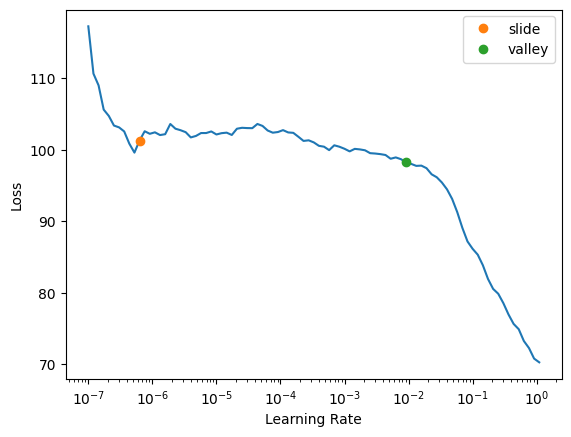

In [30]:
learn.lr_find(suggest_funcs=(slide,valley))

In [31]:
learn.fit_one_cycle(3,slice(6.509573450380412e-07, 0.009120108559727669))

epoch,train_loss,valid_loss,_rmse,time
0,3.926951,4.539420,2.130592,00:14
1,3.841202,3.569802,1.889392,00:17
2,3.627239,3.536179,1.880473,00:13


In [ ]:
learn.show_results()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Rings_pred
0,1.0,0.739773,0.744402,1.037867,0.689753,0.675277,1.016799,0.526531,17.0,10.128865
1,2.0,-1.754108,-1.805133,-1.463092,-1.445008,-1.465443,-1.447723,-1.410766,8.0,6.260065
2,1.0,0.063466,-0.122440,-0.015169,-0.285452,-0.181499,-0.141229,-0.355802,12.0,8.830783
3,2.0,-0.993263,-0.989282,-0.936575,-0.994494,-0.994338,-1.066662,-1.000289,9.0,7.511511
4,3.0,0.486157,0.489448,0.379720,0.048343,-0.301106,0.116111,0.085365,10.0,11.706523
5,2.0,-0.739648,-0.632347,-0.804945,-0.898501,-0.891818,-0.952839,-0.854512,9.0,7.842739
6,1.0,0.359350,0.132514,-0.015169,0.153063,0.431181,-0.027406,-0.010541,9.0,8.902841
7,3.0,1.204733,1.050346,1.169496,1.805676,1.351422,1.259292,1.738780,11.0,14.093764
8,2.0,-1.246878,-1.295226,-0.936575,-1.215933,-1.199379,-1.126048,-1.180592,7.0,7.153389


In [ ]:
#row, clas, probs = learn.predict(df.iloc[0])
#row.show()

In [32]:
dl = learn.dls.test_dl(test_df)

In [33]:
nn_preds = learn.get_preds(dl=dl)
nn_preds

(tensor([[ 9.4156],
         [ 9.7160],
         [10.2973],
         ...,
         [12.6383],
         [13.3226],
         [ 8.6164]]),
 None)

In [38]:
#nn_preds_x = learn.get_preds()[0]
#nn_preds_x

In [39]:
#nn_argmax = nn_preds_x.argmax(dim=1)
#nn_argmax

In [ ]:
!ls

kaggle.json  models  sample_data  sub-tree.csv


In [34]:
target_preds = nn_preds[0]

In [35]:
test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['id','Rings'], index=False)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,90615,9.415621
1,90616,9.716002
2,90617,10.297346
3,90618,10.079777
4,90619,7.675570


In [36]:
ls

kaggle.json  models/  sample_data/  submission.csv


In [37]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 3 with id column + no random seed "

100% 964k/964k [00:00<00:00, 4.03MB/s]
Successfully submitted to Regression with an Abalone Dataset

Neural Network without id column

Neural Network Ensemble

SuggestedLRs(slide=0.0063095735386013985, valley=0.005248074419796467)

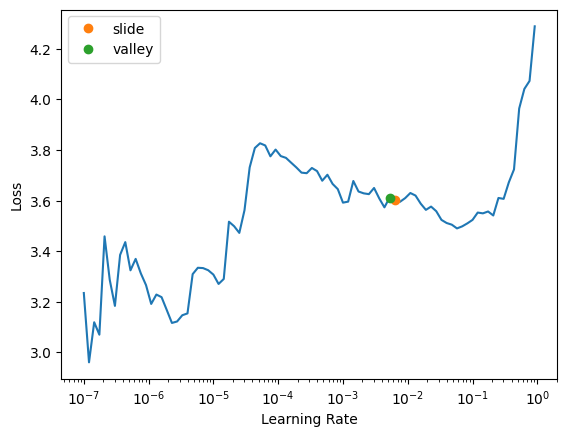

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=rmse)
    with learn.no_bar(),learn.no_logging(): learn.fit(2, 0.14)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(3)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
!ls

kaggle.json  models  sample_data


In [ ]:
submission = pd.DataFrame({
     # Assuming 'Id' is the identifier column
    'target': ens_preds
})

# Save your submission to a CSV file
submission.to_csv('submission.csv', index=False)

ValueError: If using all scalar values, you must pass an index

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub{suff}.csv', index=False)

subm(ens_preds, 'mission')

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network ensemble Sub 3 with id column + no random seed "

100% 965k/965k [00:00<00:00, 2.29MB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
#sub_df = pd.DataFrame(ens_preds, columns='Rings')
#sub_df['id'] = test_df['id']

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)

In [40]:
#targets ='Rings'
#test_df[targets] = ens_preds
#sub_df['id'] = test_df['id']

#test_df.to_csv('submission.csv', columns=['Rings'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

Random Forest

In [41]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [42]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

#roc_auc_score(y_test, rf.predict(X_test))

In [43]:
rf_preds = rf.predict(X_test)

Kaggle submission code from


https://www.kaggle.com/code/nguyncaoduy/fastai-tabular-regression-model-nn-xgb



In [44]:
dls = to.dataloaders(bs=64)

In [46]:
!ls

kaggle.json  models  sample_data


In [47]:
test_dl = dls.test_dl(test_df)

In [48]:
preds = tensor(rf.predict(test_dl.xs))
rf_preds = preds

In [49]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = rf_preds # nn_preds
submit.head()

,id,Rings
0,90615,10
1,90616,9
2,90617,9
3,90618,9
4,90619,8


In [50]:
submit.to_csv('submission.csv', index=False)

In [51]:
!ls

kaggle.json  models  sample_data  submission.csv


In [52]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,10
1,90616,9
2,90617,9
3,90618,9
4,90619,8


In [53]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "random forest initial subm trial 2 in general model nb"

100% 542k/542k [00:00<00:00, 2.00MB/s]
Successfully submitted to Regression with an Abalone Dataset